<a href="https://colab.research.google.com/github/fenzhantw/DLforeveryone/blob/main/DeepLearning_CNN(Mnist)_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Set hyper parameters - learning rate, training epochs, batch size, etc.
2. make a data pipeline - use tf.data
3. Build a neural network model - use.tf.keras sequential APIs
4. Define a loss function - cross entropy
5. Calculate a gradient - use tf.GradientTape
6. select an optimizer - Adam optimizer
7. Define a metric for models' performance - accuracy 
8. Make a checkpoint for saving
9. train and validate a neural network model

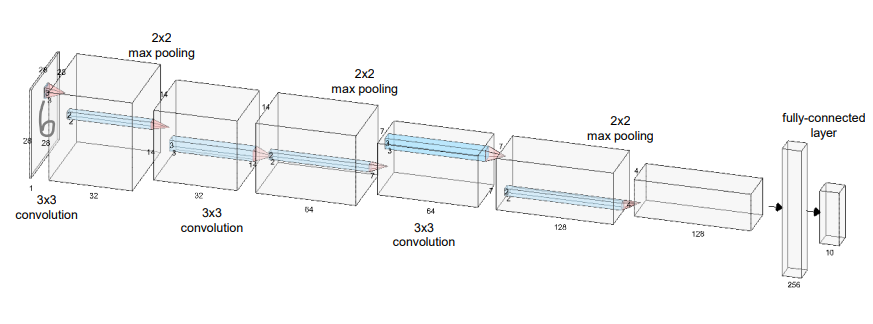

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

1. Set Hyper parameters

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

In [ ]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

2. Make a Data Pipelining

In [ ]:
mnist = keras.datasets.mnist
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

#마지막 Channel 차원 추가
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

#라벨링 one-hot 처리
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)   

#데이터를 batch size만큼 잘라서 제공, Train할 때는 데이터를 Suffle이 필요
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11501568/11490434 [==============================] - 0s 0us/step


3. Build a Neural Network Model

In [ ]:
def create_model():
    #Sequential API를 사용하면, model.add를 사용하여 레이어를 순차적으로 쌓을 수 있음
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    #Fully conneted 전에 vector를 펴주는 작업이 필요
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10))
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

4. Define a Loss Function
5. Calculate a Gradient

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

6. Select an Optimizer
7. Define a Metric for model's performance
8. make a checkpoint for saving

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

checkpoint = tf.train.Checkpoint(cnn=model)

In [ ]:
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

9.Train and validate a NN

In [ ]:
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        train(model, images, labels)
        #grads = grad(model, images, labels)                
        #optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.10862647 train accuracy =  0.9754 test accuracy =  0.9868
Epoch: 2 loss = 0.04338203 train accuracy =  0.9900 test accuracy =  0.9910
Epoch: 3 loss = 0.03036673 train accuracy =  0.9938 test accuracy =  0.9919
Epoch: 4 loss = 0.02260976 train accuracy =  0.9956 test accuracy =  0.9917
Epoch: 5 loss = 0.01833059 train accuracy =  0.9966 test accuracy =  0.9915
Epoch: 6 loss = 0.01420907 train accuracy =  0.9978 test accuracy =  0.9917
Epoch: 7 loss = 0.01232260 train accuracy =  0.9981 test accuracy =  0.9921
Epoch: 8 loss = 0.01086960 train accuracy =  0.9983 test accuracy =  0.9909
Epoch: 9 loss = 0.00997864 train accuracy =  0.9986 test accuracy =  0.9925
Epoch: 10 loss = 0.00789740 train accuracy =  0.9990 test accuracy =  0.9929
Epoch: 11 loss = 0.00830934 train accuracy =  0.9988 test accuracy =  0.9926
Epoch: 12 loss = 0.00645342 train accuracy =  0.9993 test accuracy =  0.9936
Epoch: 13 loss = 0.00617882 train accuracy =  0.

#Build a Neural Network Model
- Limitation of Sequential API

multi input을 갖는 모델 

multi-output을 갖는 모델

하나의 레이어를 여러번 반복해서 사용하는 모델

non-sequential data flow (e.g. Residual connections)

입력을 뒤에 받는 것이 특징임

#Build a Neural Network Model - subclassing

Build a fully-customizable model by subclassing tf.keras.model

create layers in the __init__ method and set them as attributes of the class inaace.(init으로 선언)

define the forward pass in the call method.(call메서드로 클래스 호출)

- 이렇게 subclass를 이용해서 CNN을 구현하면, 여러개의 모델을 동시에 학습시킨 후, 나중에 inference할때, 그 모델을 한 꺼번에 사용하는 앙상블 방법을 사용하기 편함.

In [ ]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10)
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

# using Model Ensemble

인스턴스를 여러개 생성하여, 각각 학습시켜 좋은 성능을 내게하는 앙상블 기법을 구현

In [2]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [7]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'mnist_cnn_ensemble'

checkpint_dir = os.path.join(cur_dir,ckpt_dir_name,model_dir_name)
os.makedirs(checkpint_dir,exist_ok=True)

checkpoint_prefix = os.path.join(checkpint_dir,model_dir_name)

In [9]:
mnist = keras.datasets.mnist

(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.
train_images = np.expand_dims(train_images,axis=-1)
test_images = np.expand_dims(test_images,axis=-1)

train_labels = to_categorical(train_labels,10)
test_labels = to_categorical(test_labels,10)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10)
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

# 빈 리스트에 모델 3개 어펜드
models = []
num_models =3

for m in range(num_models):
  models.append(MNISTModel())

In [11]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

In [13]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

def evaluate(models,images,lables):
  predictions = tf.zeros_like(labels)
  for model in models:
    logits = model(images,training=False)
    predictions += logits
  correct_prediction = tf.equal(tf.argmax(predictions,1),tf.argmax(labels,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
  return accuracy

checkpoints = []
for m in range(num_models):
  checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

In [14]:
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        for model in models:
            #train(model, images, labels)
            grads = grad(model, images, labels)                
            optimizer.apply_gradients(zip(grads, model.variables))
            loss = loss_fn(model, images, labels)
            avg_loss += loss / num_models
        acc = evaluate(models, images, labels)
        avg_train_acc += acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(models, images, labels)        
        avg_test_acc += acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    
    for idx, checkpoint in enumerate(checkpoints):
        checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.15859535 train accuracy =  0.9632 test accuracy =  0.9899
Epoch: 2 loss = 0.03884329 train accuracy =  0.9933 test accuracy =  0.9926
Epoch: 3 loss = 0.02569096 train accuracy =  0.9959 test accuracy =  0.9929
Epoch: 4 loss = 0.01969248 train accuracy =  0.9973 test accuracy =  0.9933
Epoch: 5 loss = 0.01558589 train accuracy =  0.9983 test accuracy =  0.9943
Epoch: 6 loss = 0.01255957 train accuracy =  0.9988 test accuracy =  0.9939
Epoch: 7 loss = 0.01081202 train accuracy =  0.9991 test accuracy =  0.9935
Epoch: 8 loss = 0.00912410 train accuracy =  0.9993 test accuracy =  0.9947
Epoch: 9 loss = 0.00747736 train accuracy =  0.9995 test accuracy =  0.9944
Epoch: 10 loss = 0.00629980 train accuracy =  0.9996 test accuracy =  0.9948
Epoch: 11 loss = 0.00654963 train accuracy =  0.9997 test accuracy =  0.9947
Epoch: 12 loss = 0.00515558 train accuracy =  0.9998 test accuracy =  0.9952
Epoch: 13 loss = 0.00406938 train accuracy =  0.

# Best CNN with MNIST Dataset

- Data Augmentation

- Batch Normalization

- Model Ensemble

- Learning Rate Decay

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage

In [17]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'mnist_cnn_ensemble'

checkpint_dir = os.path.join(cur_dir,ckpt_dir_name,model_dir_name)
os.makedirs(checkpint_dir,exist_ok=True)

checkpoint_prefix = os.path.join(checkpint_dir,model_dir_name)

In [23]:
def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    for x, y in zip(images, labels):        
        aug_images.append(x)
        aug_labels.append(y)        
        
        bg_value = np.median(x)
        
        for _ in range(4):
            angle = np.random.randint(-15, 15, 1)            
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value)
            
            shift = np.random.randint(-2, 2, 2)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            
            aug_images.append(shift_img)
            aug_labels.append(y)
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

In [24]:
mnist = keras.datasets.mnist

(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images,train_labels = data_augmentation(train_images,train_labels)

train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.
train_images = np.expand_dims(train_images,axis=-1)
test_images = np.expand_dims(test_images,axis=-1)

train_labels = to_categorical(train_labels,10)
test_labels = to_categorical(test_labels,10)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=500000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [31]:
class ConvBNRelu(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                                        padding=padding, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer 

In [32]:
class DenseBNRelu(tf.keras.Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = keras.layers.Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = tf.keras.layers.BatchNormalization()
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        return layer

In [33]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=[3, 3], padding='SAME')        
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], padding='SAME')
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3], padding='SAME')
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10, kernel_initializer='glorot_normal')
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [34]:
models = []
num_models = 5
for m in range(num_models):
    models.append(MNISTModel())

In [35]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss   

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.trainable_variables)

def evaluate(models, images, labels):
    predictions = np.zeros_like(labels)
    for model in models:
        logits = model(images, training=False)
        predictions += logits
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [36]:
#5epoch 마다, learning_rate를 0.5만큼 줄이는 lr_decay 정의
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                          train_images.shape[0]/batch_size*num_models*5,
                                                          0.5, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)

In [37]:
checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

In [ ]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0        
    for images, labels in train_dataset:
        for model in models:
            grads = grad(model, images, labels)                
            optimizer.apply_gradients(zip(grads, model.trainable_variables))            
            loss = loss_fn(model, images, labels)
            avg_loss += loss / num_models
        acc = evaluate(models, images, labels)
        avg_train_acc += acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(models, images, labels)        
        avg_test_acc += acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    
    for idx, checkpoint in enumerate(checkpoints):
        checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx))

print('Learning Finished!')